In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
import librosa.display as ld
import pyaudio
import wave
import sys
import hashlib
import mysql.connector
import time
import os

In [2]:
# the file name output you want to record into
filename = input('Enter the name of the recording')+'.wav'
# set the chunk size of 1024 samples
chunk = 1024
# sample format
FORMAT = pyaudio.paInt16
# mono, change to 2 if you want stereo
channels = 1
# 44100 samples per second
sample_rate = 44100
record_seconds = 5
# initialize PyAudio object
p = pyaudio.PyAudio()
# open stream object as input & output
stream = p.open(format=FORMAT,
                channels=channels,
                rate=sample_rate,
                input=True,
                output=True,
                frames_per_buffer=chunk)
frames = []
print("Recording...")
for i in range(int(44100 / chunk * record_seconds)):
    data = stream.read(chunk)
    # if you want to hear your voice while recording
    # stream.write(data)
    frames.append(data)
print("Finished recording.")
# stop and close stream
stream.stop_stream()
stream.close()
# terminate pyaudio object
p.terminate()
# save audio file
# open the file in 'write bytes' mode
wf = wave.open(filename, "wb")
# set the channels
wf.setnchannels(channels)
# set the sample format
wf.setsampwidth(p.get_sample_size(FORMAT))
# set the sample rate
wf.setframerate(sample_rate)
# write the frames as bytes
wf.writeframes(b"".join(frames))
# close the file
wf.close()

Enter the name of the recordingsong
Recording...
Finished recording.


In [3]:
start_time = time.time()

In [4]:
ipd.Audio(filename)

(-1.0, 1.0)

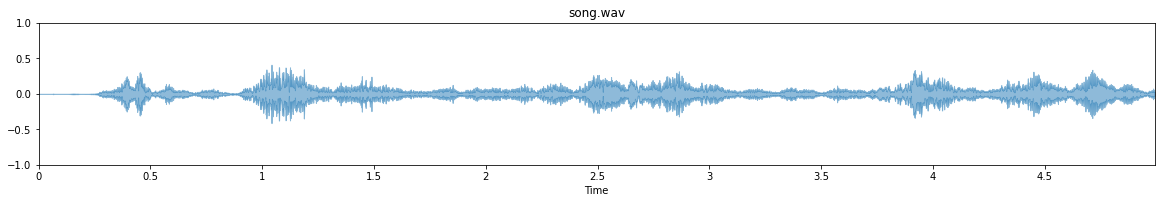

In [5]:
recarr,sr=librosa.load(filename)
plt.figure(figsize=(20,12))
plt.subplot(4,1,1)
ld.waveplot(recarr,alpha=0.5)
plt.title(filename)
plt.ylim(-1,1)

In [6]:
def ftransform(signal,title,sr,f_ratio):
    ft=np.fft.fft(signal)
    mag_spec=np.abs(ft)
    
    plt.figure(figsize=(12,5))
    frequency=np.linspace(0,sr,len(mag_spec))
    num_freq_bins=int(len(frequency)*f_ratio)
    plt.plot(frequency[:num_freq_bins],mag_spec[:num_freq_bins])
    plt.xlabel('Frequency')
    plt.title(title)
    
    plt.show()

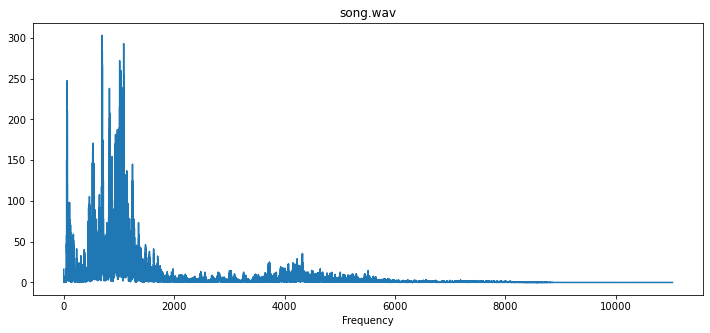

In [7]:
ftransform(recarr,filename,sr,0.5)

In [8]:
FRAME_SIZE=2048
HOP_SIZE=512

In [9]:
stft_recarr=librosa.stft(recarr,n_fft=FRAME_SIZE,hop_length=HOP_SIZE)

In [10]:
Y_recarr=(np.abs(stft_recarr))**2

In [11]:
def plot_spectrogram(Y,sr,hop_length,y_axis='linear'):
    plt.figure(figsize=(25,10))
    librosa.display.specshow(Y,
                             sr=sr,
                             hop_length=hop_length,
                             x_axis='time',
                             y_axis=y_axis)
    plt.colorbar(format='%+0.2f')

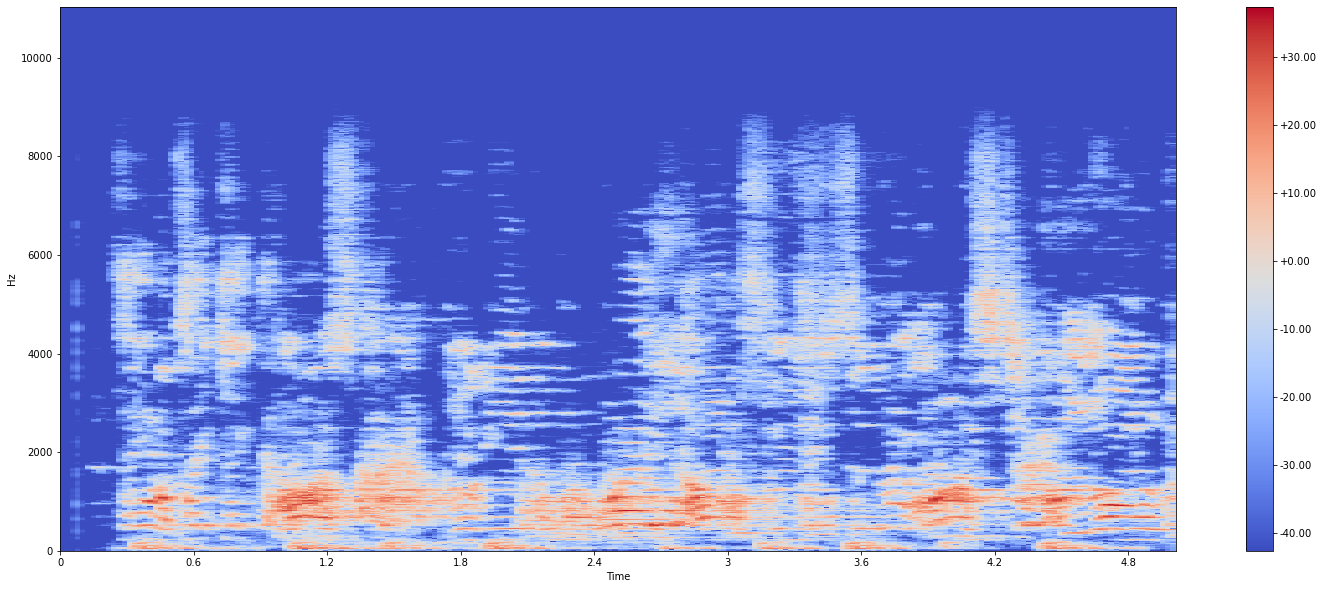

In [12]:
Y_log_recarr=librosa.power_to_db(Y_recarr)
plot_spectrogram(Y_log_recarr,sr,HOP_SIZE)

In [13]:
'''
m,n=Y_recarr.shape
old=Y_recarr.copy()
counts=0
wq=np.zeros((m,n))
for i in range(m-49):
    for j in range(n-49):
        max=old[i][j]
        for g in range(50):
            for z in range(50):
                if old[i+g][j+z]>max:
                    max=old[i+g][j+z]
        for g in range(50):
            for z in range(50):
                if old[i+g][j+z]==max:
                    wq[i+g][j+z]=1 
                    counts=counts+1
print(wq)
print(counts)
print(m,n)
'''

'\nm,n=Y_recarr.shape\nold=Y_recarr.copy()\ncounts=0\nwq=np.zeros((m,n))\nfor i in range(m-49):\n    for j in range(n-49):\n        max=old[i][j]\n        for g in range(50):\n            for z in range(50):\n                if old[i+g][j+z]>max:\n                    max=old[i+g][j+z]\n        for g in range(50):\n            for z in range(50):\n                if old[i+g][j+z]==max:\n                    wq[i+g][j+z]=1 \n                    counts=counts+1\nprint(wq)\nprint(counts)\nprint(m,n)\n'

In [14]:
m,n=Y_recarr.shape
final_matrix = np.zeros((m,n))

for i in range(0,m-99):
    for j in range(0,n-99):
        mat = Y_recarr[i:i+100,j:j+100]
        r,c, = np.where(mat == np.amax(mat))
        final_matrix[(r+i),(j+c)] = 1
        
print(final_matrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [15]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  passwd="pranav9018",
  database="songsdb"
)

In [16]:
mycursor=mydb.cursor()
hashes=list([])
for i in range(10,m-10):
    for j in range(n-100):
        if final_matrix[i][j]==1:
            ll,ul=j+10,j+100
            lb,ub=i-10,i+10
            for y in range(lb,ub+1):
                for x in range(ll,ul+1):
                    if final_matrix[y][x]==1:
                        hashvalue=hashlib.sha224(f"{str(i)}|{str(y)}|{str(x-j)}".encode('utf-8')).hexdigest()
                        value=[hashvalue,i]
                        prompt="INSERT INTO rechashes (hashes, recoffset) VALUES (%s, %s)"
                        mycursor.execute(prompt,value)
                        mydb.commit()                      

In [17]:
'''import time
start_time = time.time()
mycursor=mydb.cursor()
hashes=list([])
for i in range(10,m-10):
    for j in range(n-100):
        if final_matrix[i][j]==1:
            auxi=final_matrix[i-10:i+10,j+10:j+30]
            print(auxi)
            for ele in auxi:
                o,f = np.where(auxi == 1)
                #print(o,f)
                hashvalue=hashlib.sha224(f"{str(i)}|{str(i-10+int(abs(o)))}|{str(int(abs(f))+10-j)}".encode('utf-8')).hexdigest()
                value=[hashvalue]
                prompt="INSERT INTO sample.checking(hashval_) VALUES (%s)"
                mycursor.execute(prompt,value)
                mydb.commit()
print("--- %s seconds ---" % (time.time() - start_time)) '''                       

'import time\nstart_time = time.time()\nmycursor=mydb.cursor()\nhashes=list([])\nfor i in range(10,m-10):\n    for j in range(n-100):\n        if final_matrix[i][j]==1:\n            auxi=final_matrix[i-10:i+10,j+10:j+30]\n            print(auxi)\n            for ele in auxi:\n                o,f = np.where(auxi == 1)\n                #print(o,f)\n                hashvalue=hashlib.sha224(f"{str(i)}|{str(i-10+int(abs(o)))}|{str(int(abs(f))+10-j)}".encode(\'utf-8\')).hexdigest()\n                value=[hashvalue]\n                prompt="INSERT INTO sample.checking(hashval_) VALUES (%s)"\n                mycursor.execute(prompt,value)\n                mydb.commit()\nprint("--- %s seconds ---" % (time.time() - start_time)) '

In [18]:
mycursor=mydb.cursor()
message="SELECT song_id,hashval_,offset_ FROM songsource"
mycursor.execute(message)
lamb=mycursor.fetchall()

In [19]:
mycursor=mydb.cursor()
message="SELECT hashes,recoffset FROM rechashes"
mycursor.execute(message)
chi=mycursor.fetchall()

In [20]:
lo=[{},{},{},{},{},{},{},{},{}]
for mem,n in chi:
    emp=list([])
    for songid,ele,dboff in lamb:
        if mem==ele:
            emp.append((songid,dboff))
    for fri in emp:
        di=lo[fri[0]-1]
        ite=0
        for word in di:
            if (fri[1]-n) == word:
                di[word]+=1
                ite+=1
        if ite==0:
            di[(fri[1]-n)]=1

In [21]:
lo

[{0: 1}, {0: 19}, {0: 20}, {0: 4}, {0: 1}, {}, {}, {}, {}]

In [22]:
max=0
reqnum=0
for terms in lo:
    reqnum+=1
    final_di=terms
    for k in final_di:
        if final_di[k]>max:
            max=final_di[k]
            snum=reqnum
pass_str="SELECT Song_name FROM ref WHERE song_id= %s "
pass_val=[snum]
mycursor.execute(pass_str,pass_val)
finalres=(mycursor.fetchall())
print("The recording is from the song",(finalres[0])[0])

The recording is from the song Godzilla


In [23]:
mycursor.execute("TRUNCATE TABLE rechashes")

In [24]:
print("--- %s seconds ---" % (time.time() - start_time))  

--- 20.526252508163452 seconds ---


In [25]:
os.remove(filename)